In [3]:
## Initial Exploration of the 311 data
#####################################################################
# This file explores the Analyze Boston 311 data
# to import the data we must first run the import-311-data.py file
# this file also loads pandas
#####################################################################
import matplotlib.pyplot as plt

%run -t import-311-data.py

/Users/jacobpstein/Documents/Georgetown SCS/capstone/boston-crime/02 code/import-311-data.py:24: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(url) for url in urls]
/Users/jacobpstein/Documents/Georgetown SCS/capstone/boston-crime/02 code/import-311-data.py:24: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(url) for url in urls]



IPython CPU timings (estimated):
  User   :      17.80 s.
  System :       7.66 s.
Wall time:     183.92 s.


In [8]:
# let's see how many rows and columns we have
df_311.shape

In [12]:
# total unique observations per column
df_311.nunique()

case_enquiry_id                   2407106
open_dt                           2190425
target_dt                         1264122
closed_dt                         2139951
ontime                                  2
case_status                             2
closure_reason                    1777009
case_title                          23029
subject                                14
reason                                 54
type                                  210
queue                                 193
department                             18
submittedphoto                     701285
closedphoto                        353824
location                           146373
fire_district                          12
pwd_district                           22
city_council_district                  11
police_district                        24
neighborhood                           24
neighborhood_services_district         17
ward                                   56
precinct                          

<AxesSubplot:xlabel='date'>

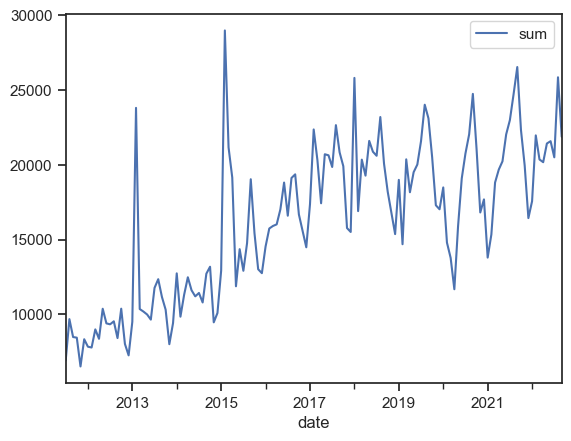

In [93]:
# convert the closed date to a date time format
df_311['closed_dt'] = pd.to_datetime(df_311['closed_dt'])

# collapse dates down to month-year
df_311['close_date'] = df_311['closed_dt'].dt.to_period('M')

# convert our closed variable to binary, 1/0
df_311['closed'] = df_311['case_status'].apply(lambda x: 1 if x=='Closed' else 0)

# get the total number of closed calls by month
closed_calls = df_311.groupby(['close_date']).agg({'closed': ['sum']}).reset_index()

# rename the columns
closed_calls.columns = ['date', 'sum']

# set date as the row index
closed_calls = closed_calls.set_index("date")

# take a look
closed_calls.plot()

In [114]:
# it looks like there is some clear seasonality in our data

df_311['close_month'] = df_311['closed_dt'].dt.month
close_month = df_311.groupby(['close_month']).agg({'closed': ['sum']}).reset_index()
close_month.columns = ['month', 'sum']

close_month.sort_values('sum', ascending=False)

,month,sum
7,8.0,218710
8,9.0,216341
6,7.0,195245
1,2.0,192216
5,6.0,187646
2,3.0,181712
4,5.0,180220
9,10.0,176429
3,4.0,172590
0,1.0,169557


2369

'0          2011.0\n1          2011.0\n2          2011.0\n3          2011.0\n4          2011.0\n            ...  \n2407101    2022.0\n2407102    2022.0\n2407103    2022.0\n2407104       NaN\n2407105    2022.0\nName: close_year, Length: 2407106, dtype: float64-0          7.0\n1          7.0\n2          8.0\n3          7.0\n4          7.0\n          ... \n2407101    1.0\n2407102    1.0\n2407103    1.0\n2407104    NaN\n2407105    1.0\nName: close_month, Length: 2407106, dtype: float64'

0          2011-07
1          2011-07
2          2011-08
3          2011-07
4          2011-07
            ...   
2407101    2022-01
2407102    2022-01
2407103    2022-01
2407104        NaT
2407105    2022-01
Name: closed_dt, Length: 2407106, dtype: period[M]